# Setup

## [참고문서](https://stackademic.com/blog/rag-using-llama3-langchain-and-chromadb-77bba0154df4)

## install

In [1]:
!pip install -U transformers==4.33.0 accelerate==0.22.0 einops==0.6.1 langchain==0.0.300 xformers==0.0.21 bitsandbytes==0.41.1 sentence_transformers==2.2.2 chromadb==0.4.12 pypdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.2/152.2 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## HF_TOKEN

In [2]:
import os
os.environ['HF_TOKEN'] = "huggingface api token"

## 구글 드라이브 연결

In [3]:
# 구글 드라이브 연결(데이터 로드를 위해서)
try:
    from google.colab import drive

    drive.mount('/content/data')
    DATA_PATH = "/content/data/MyDrive/ai_lecture/3. Large Language Models/data/"
except:
    DATA_PATH = "./data/"

Mounted at /content/data


## import

In [4]:
import sys
from torch import cuda, bfloat16
import torch
import transformers
from transformers import AutoTokenizer
from time import time
#import chromadb
#from chromadb.config import Settings
from langchain.llms import HuggingFacePipeline
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.chains import RetrievalQA
from langchain.vectorstores import Chroma


# Initialize model, tokenizer, query pipeline

## Define the model, the device, and the bitsandbytes configuration.

In [5]:
model_id = 'meta-llama/Meta-Llama-3-8B-Instruct'

device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

# set quantization configuration to load large model with less GPU memory
# this requires the `bitsandbytes` library
bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=bfloat16
)

print(device)


cuda:0


## Prepare the model and the tokenizer.

In [6]:
time_start = time()
model_config = transformers.AutoConfig.from_pretrained(
   model_id,
    trust_remote_code=True,
    max_new_tokens=1024
)
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    config=model_config,
    quantization_config=bnb_config,
    device_map='auto',
)
tokenizer = AutoTokenizer.from_pretrained(model_id)
time_end = time()
print(f"Prepare model, tokenizer: {round(time_end-time_start, 3)} sec.")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Prepare model, tokenizer: 71.572 sec.


## Define the query pipeline.

In [7]:
time_start = time()
query_pipeline = transformers.pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        torch_dtype=torch.float16,
        max_length=1024,
        device_map="auto",)
time_end = time()
print(f"Prepare pipeline: {round(time_end-time_start, 3)} sec.")


Prepare pipeline: 1.375 sec.


## Define a function for testing the pipeline.

In [8]:
def test_model(tokenizer, pipeline, message):
    """
    Perform a query
    print the result
    Args:
        tokenizer: the tokenizer
        pipeline: the pipeline
        message: the prompt
    Returns
        None
    """
    time_start = time()
    sequences = pipeline(
        message,
        do_sample=True,
        top_k=10,
        num_return_sequences=1,
        eos_token_id=tokenizer.eos_token_id,
        max_length=200,)
    time_end = time()
    total_time = f"{round(time_end-time_start, 3)} sec."

    question = sequences[0]['generated_text'][:len(message)]
    answer = sequences[0]['generated_text'][len(message):]

    return f"Question: {question}\nAnswer: {answer}\nTotal time: {total_time}"


# Test the query pipeline

In [9]:
from IPython.display import display, Markdown
def colorize_text(text):
    for word, color in zip(["Reasoning", "Question", "Answer", "Total time"], ["blue", "red", "green", "magenta"]):
        text = text.replace(f"{word}:", f"\n\n**<font color='{color}'>{word}:</font>**")
    return text


## Let’s test now the pipeline with few queries.

In [10]:
response = test_model(tokenizer,
                    query_pipeline,
                   "Please explain what is EU AI Act.")
display(Markdown(colorize_text(response)))


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.




**<font color='red'>Question:</font>** Please explain what is EU AI Act.


**<font color='green'>Answer:</font>**  The EU AI Act is a proposed regulation that aims to establish a framework for the development, deployment, and use of artificial intelligence (AI) in the European Union. The regulation is intended to promote the safe and trustworthy development and use of AI, while also addressing potential risks and challenges associated with AI.

The EU AI Act proposes a number of measures to achieve these goals, including:

1. Establishing a clear definition of AI and its applications
2. Setting standards for the development and testing of AI systems
3. Implementing a risk assessment and mitigation framework for AI systems
4. Regulating the use of AI in critical sectors, such as healthcare, finance, and transportation
5. Promoting transparency and accountability in the development and use of AI
6. Encouraging the development of AI for social good and the mitigation of negative impacts

The EU AI Act is still in the proposal stage and has not yet been adopted. However, it is


**<font color='magenta'>Total time:</font>** 20.74 sec.

# RAG — Check the model with a Hugging Face pipeline

In [11]:
llm = HuggingFacePipeline(pipeline=query_pipeline)

# checking again that everything is working fine
time_start = time()
question = "Please explain what EU AI Act is."
response = llm(prompt=question)
time_end = time()
total_time = f"{round(time_end-time_start, 3)} sec."
full_response =  f"Question: {question}\nAnswer: {response}\nTotal time: {total_time}"
display(Markdown(colorize_text(full_response)))


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.




**<font color='red'>Question:</font>** Please explain what EU AI Act is.


**<font color='green'>Answer:</font>**  It's a great topic to discuss. What are the main goals and objectives of this Act, and how will it impact the AI industry and society as a whole?

The EU AI Act, officially known as the Regulation on Artificial Intelligence (AI) (EU) 2021/0066, is a set of rules and regulations aimed at ensuring the development and deployment of trustworthy and safe AI systems in the European Union. The Act was adopted by the European Parliament and Council in April 2021 and will come into effect in the coming years.

The main goals and objectives of the EU AI Act are:

1. **Ensuring Trustworthiness**: The Act aims to ensure that AI systems are developed and deployed in a way that is trustworthy, transparent, and explainable. This includes requirements for AI system developers to provide clear and understandable information about their AI systems, including their capabilities, limitations, and potential biases.
2. **Preventing Harm**: The Act aims to prevent harm caused by AI systems, including harm to individuals, society, and the environment. This includes requirements for AI system developers to ensure that their systems are designed and tested to minimize potential harm.
3. **Promoting Transparency**: The Act aims to promote transparency in the development and deployment of AI systems. This includes requirements for AI system developers to provide clear and understandable information about their AI systems, including their capabilities, limitations, and potential biases.
4. **Protecting Fundamental Rights**: The Act aims to protect fundamental rights, including the right to privacy, data protection, and non-discrimination. This includes requirements for AI system developers to ensure that their systems are designed and deployed in a way that respects these fundamental rights.

The EU AI Act will impact the AI industry and society as a whole in several ways:

1. **Increased Transparency**: The Act will require AI system developers to provide clear and understandable information about their AI systems, which will increase transparency and accountability.
2. **Improved Trustworthiness**: The Act will ensure that AI systems are developed and deployed in a way that is trustworthy, transparent, and explainable, which will increase trust in AI systems.
3. **Reduced Risk of Harm**: The Act will reduce the risk of harm caused by AI systems, including harm to individuals, society, and the environment.
4. **Enhanced Protection of Fundamental Rights**: The Act will protect fundamental rights, including the right to privacy, data protection, and non-discrimination, which will ensure that AI systems are developed and deployed in a way that respects these fundamental rights.

Overall, the EU AI Act is an important step towards ensuring the development and deployment of trustworthy and safe AI systems in the European Union. It will promote transparency, trustworthiness, and accountability in the AI industry, while also protecting fundamental rights and reducing the risk of harm caused by AI systems.


**<font color='magenta'>Total time:</font>** 49.597 sec.

# [Ingestion of data using PyPDFLoader](https://www.kaggle.com/datasets/konradb/eu-ai-act-complete-text/data)

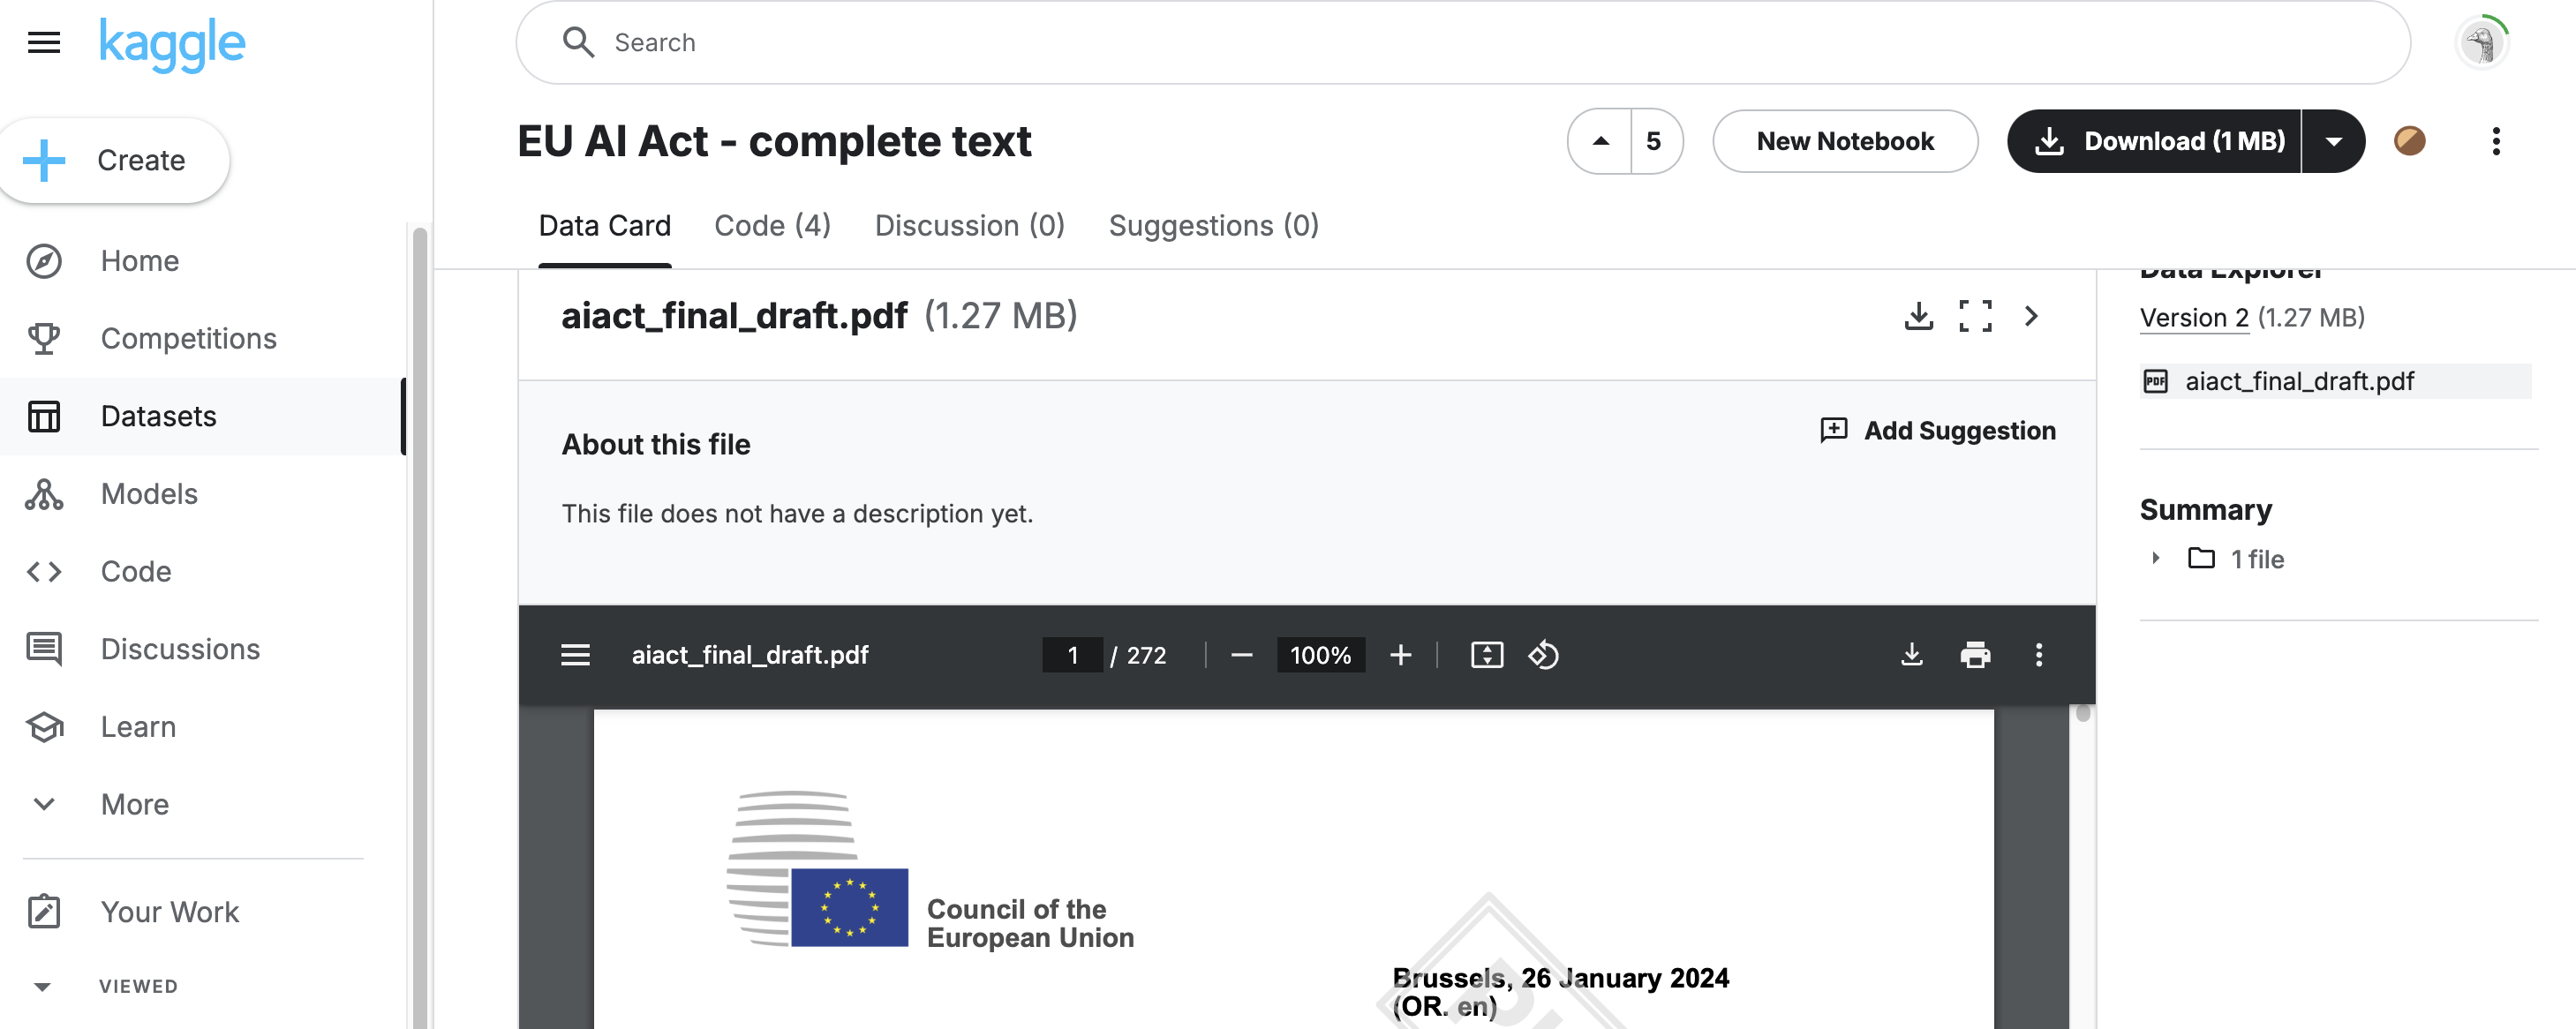

In [12]:
loader = PyPDFLoader(DATA_PATH+"aiact_final_draft.pdf")
documents = loader.load()

# Split data in chunks

In [13]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
all_splits = text_splitter.split_documents(documents)

# Creating Embeddings and Storing in Vector Store

In [14]:
model_name = "sentence-transformers/all-mpnet-base-v2"
model_kwargs = {"device": "cuda"}

# try to access the sentence transformers from HuggingFace: https://huggingface.co/api/models/sentence-transformers/all-mpnet-base-v2
embeddings = HuggingFaceEmbeddings(model_name=model_name, model_kwargs=model_kwargs)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'cached_download' (from 'huggingface_hub.file_download') is deprecated and will be removed from version '0.26'. Use `hf_hub_download` instead.
  warnings.warn(warning_message, FutureWarning)


.gitattributes:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

- Initialize ChromaDB with the document splits, the embeddings defined previously and with the option to persist it locally.

In [15]:
vectordb = Chroma.from_documents(documents=all_splits, embedding=embeddings, persist_directory="chroma_db")


# Initialize chain

In [16]:
retriever = vectordb.as_retriever()

qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever,
    verbose=True
)


# Test the Retrieval-Augmented Generation

In [17]:
def test_rag(qa, query):

    time_start = time()
    response = qa.run(query)
    time_end = time()
    total_time = f"{round(time_end-time_start, 3)} sec."

    full_response =  f"Question: {query}\nAnswer: {response}\nTotal time: {total_time}"
    display(Markdown(colorize_text(full_response)))


In [18]:
query = "How is performed the testing of high-risk AI systems in real world conditions?"
test_rag(qa, query)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.




> Entering new RetrievalQA chain...

> Finished chain.




**<font color='red'>Question:</font>** How is performed the testing of high-risk AI systems in real world conditions?


**<font color='green'>Answer:</font>**  According to Article 7, the testing of high-risk AI systems in real world conditions is performed, as appropriate, at any point in time throughout the development process, and, in any event, prior to the placing on the market or the putting into service. The testing is made against prior defined metrics. According to Article 8, providers or prospective providers may conduct testing of high-risk AI systems in real world conditions at any time before the placing on the market or putting into service of the AI system on their own or in partnership with one or more prospective deployers. The testing is performed where all of the following conditions are met: the provider or prospective provider has drawn up a real world testing plan and submitted it to the market surveillance authority in the Member State(s) where the testing in real world conditions is to be conducted. The testing plan takes into account the intended purpose and the context of use of the AI system and according to the risk management system to be established by the provider or prospective provider.


**<font color='magenta'>Total time:</font>** 18.809 sec.

In [19]:
query = "What are the operational obligations of notified bodies?"
test_rag(qa, query)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.




> Entering new RetrievalQA chain...

> Finished chain.




**<font color='red'>Question:</font>** What are the operational obligations of notified bodies?


**<font color='green'>Answer:</font>**  According to Article 34a of the Regulation, the operational obligations of notified bodies are to verify the conformity of high-risk AI systems in accordance with the conformity assessment procedures referred to in Article 43. They must also ensure that their personnel, committees, subsidiaries, subcontractors, and associated bodies or personnel of external authority have the necessary expertise and are impartial in their activities. Additionally, notified bodies must take full responsibility for the tasks performed by subcontractors or subsidiaries, and they must keep relevant documents concerning the assessment of the qualifications of subcontractors or subsidiaries and the work carried out by them for a period of 5 years from the termination date of the subcontracting activity. (Source: Regulation (EU) 2019/513, Article 34a)


**<font color='magenta'>Total time:</font>** 14.042 sec.

# Document sources

In [20]:
docs = vectordb.similarity_search(query)
print(f"Query: {query}")
print(f"Retrieved documents: {len(docs)}")
for doc in docs:
    doc_details = doc.to_json()['kwargs']
    print("Source: ", doc_details['metadata']['source'])
    print("Text: ", doc_details['page_content'], "\n")


Query: What are the operational obligations of notified bodies?
Retrieved documents: 4
Source:  /content/data/MyDrive/ai_lecture/3. Large Language Models/data/aiact_final_draft.pdf
Text:  5.
 
Notified bodies shall be organised and operated so as to safeguard the independence, 
objectivity and impartiality of their activities. Notified b
odies shall document and 
implement a structure and procedures to safeguard impartiality and to promote and apply 
the principles of impartiality throughout their organisation, personnel and assessment 
activities.
 
6.
 
Notified bodies shall have documented pro
cedures in place ensuring that their personnel, 
committees, subsidiaries, subcontractors and any associated body or personnel of external 

Source:  /content/data/MyDrive/ai_lecture/3. Large Language Models/data/aiact_final_draft.pdf
Text:  authority accordingly.
 
2.
 
Notified bodies
 
shall take full responsibility for the tasks performed by subcontractors or 
subsidiaries wherever these a